<a href="https://colab.research.google.com/github/pathikg/Flower-Classification/blob/main/Flower_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!nvidia-smi 

Mon Oct 18 15:52:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os 
import pandas as pd 
import pickle 
import random 
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation, Input,  Rescaling
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

In [4]:
tf.__version__ 

'2.6.0'

setting up main directory


In [5]:
os.chdir("/content/drive/MyDrive/Flower classification/")

## Dataset info

Dataset is available at https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/1ECTVN

Our dataset contains 5 different types of flowers having 600-800 images for each type :
1. daisy
2. dandelion 
3. roses 
4. sunflowers
5. tulips

## Looking around the data

In [6]:
os.listdir("./flowers/flower_photos")

['.DS_Store', 'train', 'validation', 'test']

So we already have 3 different subsets for train, test and validation !

In [7]:
os.listdir("./flowers/flower_photos/train")

['sunflowers', 'roses', 'daisy', 'dandelion', 'tulips']

In [8]:
print("Number of images per flower type")
for class_name in os.listdir("./flowers/flower_photos/train"):
    class_path = os.path.join("./flowers/flower_photos/train", class_name)
    print(f"{class_name}:{len(os.listdir(class_path))}")

Number of images per flower type
sunflowers:673
roses:615
daisy:607
dandelion:872
tulips:773


### Just looking at one sample image

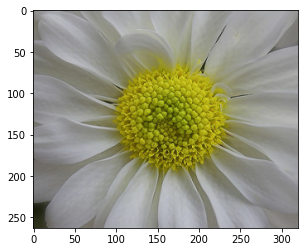

In [9]:
img = cv2.imread("./flowers/flower_photos/train/daisy/100080576_f52e8ee070_n.jpg", 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img);

In [10]:
img.shape

(263, 320, 3)

## Let's load the data 

In [11]:
train_dir = "./flowers/flower_photos/train"
test_dir = "./flowers/flower_photos/test"
valid_dir = "./flowers/flower_photos/validation"
classes = os.listdir(train_dir) # store classes of flowers

In [12]:
def load_data(dir):
    X = []
    y = []
    for class_name in os.listdir(dir):
        class_id = classes.index(class_name)
        class_path = os.path.join(dir, class_name)
        for img_name in tqdm(os.listdir(class_path)) :
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path, 1)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224,224))
            img = img / 255.0 
            img = np.array(img)
            X.append(img)
            y.append(class_id)
    return np.array(X), np.array(y) 

In [13]:
X_train, y_train = load_data(train_dir)

100%|██████████| 773/773 [00:07<00:00, 108.48it/s]


In [14]:
X_valid, y_valid = load_data(valid_dir)

100%|██████████| 16/16 [00:00<00:00, 100.15it/s]


In [15]:
X_test, y_test = load_data(test_dir)

100%|██████████| 10/10 [00:00<00:00, 126.35it/s]


In [16]:
X_train.shape

(3540, 224, 224, 3)

In [17]:
y_train.shape

(3540,)

### Converting target values to categories 

like if y1 = 0, y2 = 1, ...y5 = 4 
so our y1 will be [1,0,0,0,0],  y2 will be [0,1,0,0,0] , ...

In [18]:
y_train = tf.keras.utils.to_categorical(y_train)
y_valid = tf.keras.utils.to_categorical(y_valid)
y_test = tf.keras.utils.to_categorical(y_test)

In [19]:
y_train.shape

(3540, 5)

In [20]:
y_valid.shape

(80, 5)

### Shuffling data 

In [21]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)
X_test, y_test  = shuffle(X_test, y_test)

## Let's just visualize some flowers 
just to make sure everything is correct

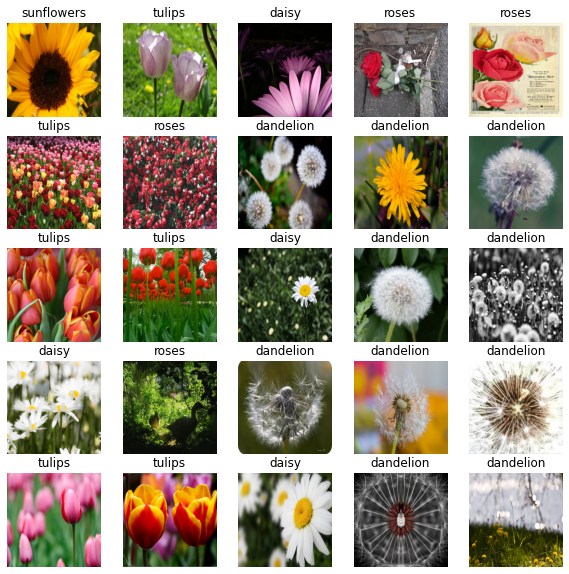

In [22]:
fig, axes = plt.subplots(5,5, figsize=(10,10))
axes = axes.flatten()

for ax in axes :
    i = np.random.randint(0,3000)
    img = X_train[i,:,:,:]
    label = classes[np.argmax(y_train[i,:])]
    ax.imshow(img)
    ax.set_title(label)
    ax.axis("off")

## Model creation

In [23]:
base_model = tf.keras.applications.vgg16.VGG16(
    input_shape = (224,224,3), include_top=False, weights='imagenet'
)
'''
Since we are using transfer learning first we freezed the weights of the VGG model by doing `base_model.trainable = False`
'''
base_model.trainable = False
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256)(x)
x = Dense(64)(x)
x = Dense(32)(x)
outputs = Dense(len(classes) , activation="softmax")(x)
model = tf.keras.Model(inputs, outputs, name="VGG16")

In [24]:
model.summary()

Model: "VGG16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 165   

for more info
https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1  

https://stackoverflow.com/questions/37213388/keras-accuracy-does-not-change


In [26]:
epochs = 50
batch_size = 32
learning_rate = 1e-2
decay = 1e-6
momentum = 0.9 # 0.5 to 0.9 
optimizer = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)

In [27]:
model.compile(
    optimizer= optimizer ,  
    loss="categorical_crossentropy",
    metrics = ["accuracy"]
)

Using EarlyStopping to stop training of model if there is no improvement 
https://stackoverflow.com/questions/43906048/which-parameters-should-be-used-for-early-stopping (2nd ans)

In [ ]:
callbacks = [
             EarlyStopping(
                 monitor='val_loss', 
                 mode='min', 
                 verbose=1, 
                 patience=10,
                 min_delta = 1e-4
            )

]

In [28]:
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data = (X_valid, y_valid),
    callbacks = callbacks
)

Epoch 1/50
111/111 [==============================] - 80s 369ms/step - loss: 1.1592 - accuracy: 0.5718 - val_loss: 0.8721 - val_accuracy: 0.6750
Epoch 2/50
111/111 [==============================] - 28s 254ms/step - loss: 0.7555 - accuracy: 0.7164 - val_loss: 1.0146 - val_accuracy: 0.6625
Epoch 3/50
111/111 [==============================] - 28s 254ms/step - loss: 0.6569 - accuracy: 0.7534 - val_loss: 1.0839 - val_accuracy: 0.6875
Epoch 4/50
111/111 [==============================] - 28s 253ms/step - loss: 0.6132 - accuracy: 0.7802 - val_loss: 0.7266 - val_accuracy: 0.7625
Epoch 5/50
111/111 [==============================] - 28s 253ms/step - loss: 0.5884 - accuracy: 0.7867 - val_loss: 0.6917 - val_accuracy: 0.7000
Epoch 6/50
111/111 [==============================] - 28s 253ms/step - loss: 0.5637 - accuracy: 0.7972 - val_loss: 0.7914 - val_accuracy: 0.7500
Epoch 7/50
111/111 [==============================] - 28s 253ms/step - loss: 0.5328 - accuracy: 0.8051 - val_loss: 0.7312 - val_ac

In [30]:
model.save("model.h5")

### Training the whole model  (training VGG weights + trained weights from last training)
(not doing cuz of RAM issues)

In [31]:
'''
Unfreeze the base_model. 
'''
# base_model.trainable = True
# model.summary()

'\nUnfreeze the base_model. \n'

In [32]:
# history = model.fit(
#     X_train, y_train,
#     batch_size=batch_size,
#     epochs=epochs,
#     validation_data = (X_valid, y_valid),
#     callbacks = callbacks
# )

In [33]:
# model.evaluate(X_test, y_test)

## Model Evaluation 

In [34]:
model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 219ms/step - loss: 1.0767 - accuracy: 0.7400


[1.0766998529434204, 0.7400000095367432]

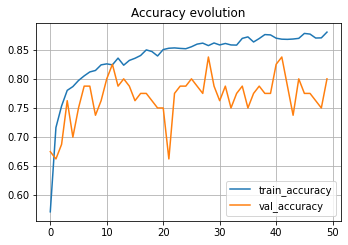

In [35]:
#Visualizing the validation performance while training
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')

plt.legend()
plt.grid()
plt.title('Accuracy evolution');

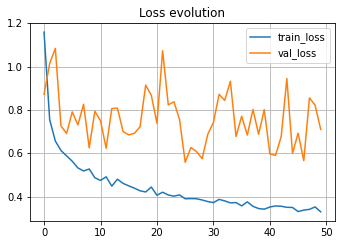

In [36]:
#Visualizing the validation performance while training
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')

plt.legend()
plt.grid()
plt.title('Loss evolution');

Need to improve :(